In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, date
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from time import time
from sklearn.svm import SVC

In [27]:
df = pd.read_csv('/media/sf_helicopter_connection/AB_NYC_2019/AB_NYC_2019.csv')

In [28]:
#Записи в базе данных по столбцам
df.count(axis=0)

id                                48895
name                              48879
host_id                           48895
host_name                         48874
neighbourhood_group               48895
neighbourhood                     48895
latitude                          48895
longitude                         48895
room_type                         48895
price                             48895
minimum_nights                    48895
number_of_reviews                 48895
last_review                       38843
reviews_per_month                 38843
calculated_host_listings_count    48895
availability_365                  48895
dtype: int64

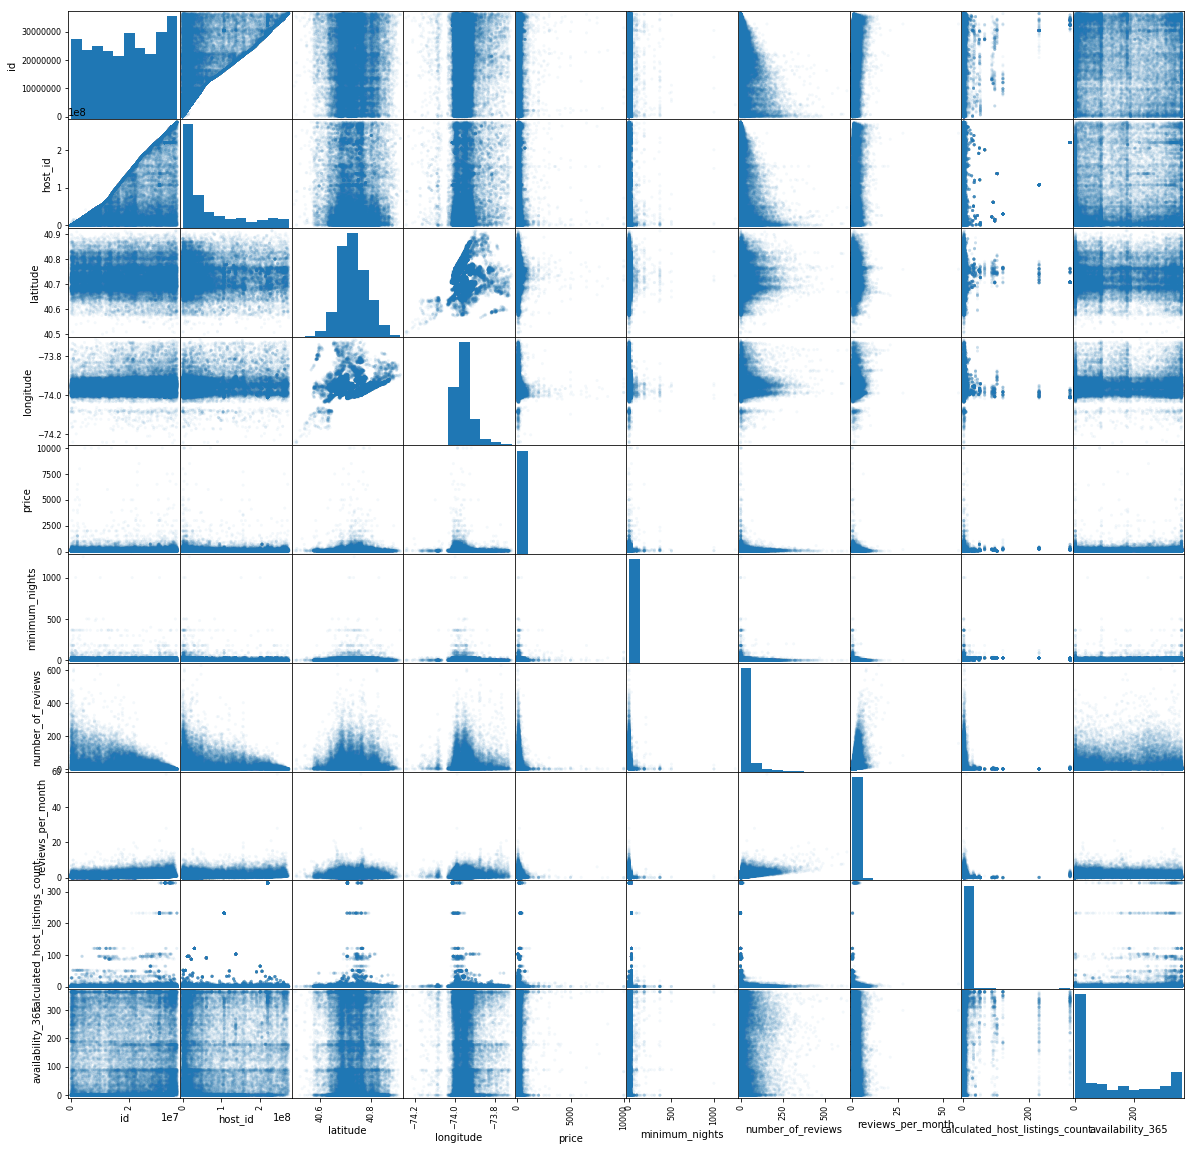

In [4]:
a = pd.plotting.scatter_matrix(df, alpha=0.05, figsize=(20, 20))

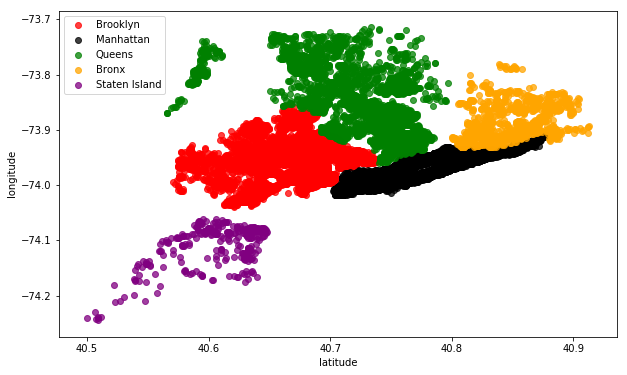

In [5]:
#группировка по районам plt
col1 = 'latitude'
col2 = 'longitude'

plt.figure(figsize=(10, 6))

plt.scatter(df[col1][df['neighbourhood_group'] == 'Brooklyn'],
            df[col2][df['neighbourhood_group'] == 'Brooklyn'],
            alpha=0.75,
            color='red',
            label='Brooklyn')
plt.scatter(df[col1][df['neighbourhood_group'] == 'Manhattan'],
            df[col2][df['neighbourhood_group'] == 'Manhattan'],
            alpha=0.75,
            color='black',
            label='Manhattan')
plt.scatter(df[col1][df['neighbourhood_group'] == 'Queens'],
            df[col2][df['neighbourhood_group'] == 'Queens'],
            alpha=0.75,
            color='green',
            label='Queens')
plt.scatter(df[col1][df['neighbourhood_group'] == 'Bronx'],
            df[col2][df['neighbourhood_group'] == 'Bronx'],
            alpha=0.75,
            color='orange',
            label='Bronx')
plt.scatter(df[col1][df['neighbourhood_group'] == 'Staten Island'],
            df[col2][df['neighbourhood_group'] == 'Staten Island'],
            alpha=0.75,
            color='purple',
            label='Staten Island')

plt.xlabel(col1)
plt.ylabel(col2)
plt.legend(loc='best');

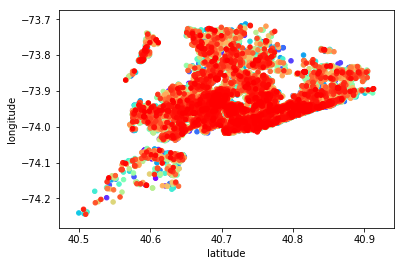

In [6]:
#группировка по цене
df.plot(kind='scatter', x='latitude', y='longitude',
        color=cm.rainbow(np.linspace(0, 1, len(df['price']))))

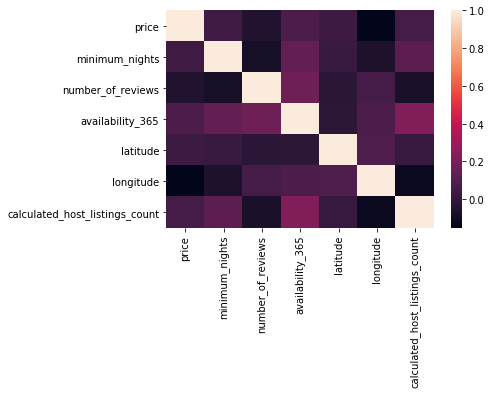

In [7]:
#корреляция
corr_matrix = df[['price', 'minimum_nights','number_of_reviews',
                      'availability_365','latitude','longitude',"calculated_host_listings_count"]].corr()
seaborn.heatmap(corr_matrix)

In [8]:
df = pd.read_csv('/media/sf_helicopter_connection/AB_NYC_2019/AB_NYC_2019.csv',
                 parse_dates=['last_review'],index_col=['id'])

categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object']

#заполняем отсутствующие значения средним в столбце 'reviews_per_month'
df['reviews_per_month'] = df['reviews_per_month'].fillna(df['reviews_per_month'].median(axis=0), axis=0)
#удаляем столбец 'last_review' и строки,где не информации в столбцах 'name', 'host_name'
del df['last_review']
df = df.dropna(axis=0,subset=['name', 'host_name'])
#заполняем все пропуски в категориальных столбцах наиболее частым значением
df_describe = df.describe(include=[object])
for c in categorical_columns:
    df[c] = df[c].fillna(df_describe[c]['top'])
#проверяем,что данные есть во всех столбцах и их одинаковое кол-во
df.count(axis=0)

name                              48858
host_id                           48858
host_name                         48858
neighbourhood_group               48858
neighbourhood                     48858
latitude                          48858
longitude                         48858
room_type                         48858
price                             48858
minimum_nights                    48858
number_of_reviews                 48858
reviews_per_month                 48858
calculated_host_listings_count    48858
availability_365                  48858
dtype: int64

In [9]:
binary_columns    = [c for c in categorical_columns if df_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if df_describe[c]['unique'] > 2]
nonbinary_columns_3 = [c for c in categorical_columns if df_describe[c]['unique'] <= 3]
print (binary_columns, nonbinary_columns)

([], ['name', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type'])


In [10]:
#все признаки не бинарные
df_nonbinary = pd.get_dummies(df[nonbinary_columns_3])
df_geo = df[[
 'latitude',
 'longitude',]]
#normal-s
df_numerical = df[[
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']]
df_numerical = (df_numerical - df_numerical.mean()) / df_numerical.std()

data = pd.concat((df_numerical, df[binary_columns], df_nonbinary, 
                  df[['neighbourhood_group']]), axis=1)

df = pd.DataFrame(data)
df.count(axis=0)

latitude                          48858
longitude                         48858
price                             48858
minimum_nights                    48858
number_of_reviews                 48858
reviews_per_month                 48858
calculated_host_listings_count    48858
availability_365                  48858
room_type_Entire home/apt         48858
room_type_Private room            48858
room_type_Shared room             48858
neighbourhood_group               48858
dtype: int64

In [11]:
# Данные для обучения
# Х - признаки  
# Y - верные ответы 

Xn = df.drop(('neighbourhood_group'), axis=1)  
Yn = df['neighbourhood_group']

X_train, X_test, Y_train, Y_test = train_test_split(Xn, Yn, test_size = 0.3, random_state = 11)

In [18]:
#Метод к ближайших соседей
def KNClass(X_train, Y_train, X_test, Y_test):
    n_neighbors_array = [i for i in range(1, 21)]
    metric_array = ['euclidean','manhattan', 'chebyshev',]
    err = {'euclidean':[],'manhattan':[], 'chebyshev':[],}
    t = {'euclidean':[],'manhattan':[], 'chebyshev':[],}
    for i in n_neighbors_array:
        for met in metric_array:
            knn = neighbors.KNeighborsClassifier(n_neighbors=i, metric=met,weights='distance')
            knn.fit(X_train, Y_train)
            t0 = time()
            y_test_predict = knn.predict(X_test)
            t1 = time()
            err[met].append(round(np.mean(Y_test  != y_test_predict)*100))
            t[met].append(round(t1-t0,5)/Y_test.size)
    p1 = pd.Series(t,index=n_neighbors_array)
    p2 = pd.Series(err,index=n_neighbors_array)
    KNeighbors_time = pd.DataFrame(t, index=n_neighbors_array)                
    KNeighbors_err = pd.DataFrame(err, index=n_neighbors_array)
    return(KNeighbors_err, KNeighbors_time)

result = KNClass(X_train, Y_train, X_test, Y_test)
print('errors:')
print(result[0])
print('time:')
print(result[1])  

errors:
    chebyshev  euclidean  manhattan
1         2.0        2.0        2.0
2         2.0        2.0        2.0
3         2.0        2.0        2.0
4         2.0        2.0        2.0
5         2.0        2.0        2.0
6         2.0        2.0        2.0
7         2.0        2.0        2.0
8         2.0        2.0        2.0
9         3.0        2.0        2.0
10        3.0        2.0        2.0
11        3.0        2.0        2.0
12        3.0        2.0        2.0
13        3.0        2.0        2.0
14        3.0        2.0        2.0
15        3.0        2.0        2.0
16        3.0        2.0        2.0
17        3.0        2.0        2.0
18        3.0        2.0        2.0
19        3.0        2.0        2.0
20        3.0        2.0        2.0
time:
    chebyshev  euclidean  manhattan
1    0.000027   0.000081   0.000142
2    0.000058   0.000101   0.000182
3    0.000048   0.000117   0.000211
4    0.000046   0.000115   0.000225
5    0.000051   0.000116   0.000258
6    0.000055 

In [14]:
#SVC
def svc(X_train, Y_train, X_test, Y_test):
    C = [i for i in range(1,6)]
    kernel = ['linear', 'rbf', 'poly', 'sigmoid']
    degree = [i for i in range(2,4)]
    err_train = []
    err_test = []
    for k in kernel:
        if k == 'linear' or k == 'rbf' or k == 'sigmoid':
            for c in C:
                svc = SVC(C=c, kernel=k)
                svc.fit(X_train, Y_train)
                t1 = time()
                train_pred = round(np.mean(Y_train != svc.predict(X_train))*100, 2)
                t2 = time()
                test_pred = round(np.mean(Y_test != svc.predict(X_test))*100, 2)
                t3 = time()
                err_train.append([k, 'ignored', c, train_pred,round(t2-t1,5)/Y_train.size])
                err_test.append([k, 'ignored', c, test_pred,round(t3-t2,5)/Y_test.size])
        if k == 'poly':
            for d in degree:
                for c in C:
                    svc = SVC(C=c, kernel=k, degree=d)
                    t0 = time()
                    svc.fit(X_train, Y_train)
                    t1 = time()
                    train_pred = round(np.mean(Y_train != svc.predict(X_train))*100, 2)
                    t2 = time()
                    test_pred = round(np.mean(Y_test != svc.predict(X_test))*100, 2)
                    t3 = time()
                    err_train.append([k, d, c, train_pred,round(t2-t1,5)/Y_train.size])
                    err_test.append([k, d, c, test_pred,round((t3-t2),5)/Y_test.size])
    
    return(err_train, err_test)

(train, test) = svc(X_train, Y_train, X_test, Y_test)

In [25]:
kernel = ['linear', 'rbf', 'poly', 'sigmoid']
print('train:')
print('kernel, degree, C, error, time')
for k in kernel:
    temp = 100
    num = 0
    for i in range(0, len(train)):
        if train[i][0] == k:
            if train[i][3] < temp:
                temp = train[i][3]
                num = i        
    print(train[num])

print('test:')
print('kernel, degree, C, error, time')
for k in kernel:
    temp = 100
    num = 0
    for i in range(0, len(test)):
        if test[i][0] == k:
            if test[i][3] < temp:
                temp = test[i][3]
                num = i        
    print(test[num])

train:
kernel, degree, C, error, time
['linear', 'ignored', 3, 1.18, 5.203538011695906e-05]
['rbf', 'ignored', 5, 0.66, 0.00011369181286549707]
['poly', 2, 5, 1.34, 0.00012145029239766082]
['sigmoid', 'ignored', 1, 13.23, 0.0003695637426900585]
test:
kernel, degree, C, error, time
['linear', 'ignored', 2, 1.11, 5.0871878837494885e-05]
['rbf', 'ignored', 5, 0.89, 0.00011411652340019102]
['poly', 3, 5, 1.39, 0.0001528523673079547]
['sigmoid', 'ignored', 1, 12.87, 0.0003664040114613181]


In [21]:
from sklearn.tree import DecisionTreeClassifier

def dectree(X_train, Y_train, X_test, Y_test, integer=False):
    err = []
    depth = [i for i in range(1,16)]
    crit = ['gini', 'entropy']
    split = ['best', 'random']
    random = [i for i in range(1,6)]
    
    for s in split:
        for c in crit:
            for r in random:
                for d in depth:
                    clf_tree = DecisionTreeClassifier(criterion=c, max_depth=d, random_state=r, splitter=s, presort=True)
                    clf_tree.fit(X=X_train, y=Y_train)
                    if integer:
                        err_train = round(np.mean(Y_train != clf_tree.predict(X_train).astype('int'))*100, 2)
                        t1 = time()
                        err_test  = round(np.mean(Y_test  != clf_tree.predict(X_test).astype('int'))*100, 2)
                    else:
                        err_train = round(np.mean(Y_train != clf_tree.predict(X_train))*100, 2)
                        t1 = time()
                        err_test  = round(np.mean(Y_test  != clf_tree.predict(X_test))*100, 2)
                        t2 = time()
                    err.append([s,c,r,d,err_test,round(t2 - t1,5)/Y_test.size])
    return err
err = dectree(X_train, Y_train, X_test, Y_test)

In [24]:
crit = ['gini', 'entropy']
print('splitter, criteria, random, depth, error, time')
for c in crit:
    temp = 100
    num = 0
    for i in range(0, len(err)):
        if err[i][1] == c:
            if err[i][4] < temp:
                temp = err[i][4]
                num = i        
    print(err[num])

splitter, criteria, random, depth, error, time
['best', 'gini', 4, 10, 0.12, 4.7073270568972575e-07]
['best', 'entropy', 5, 10, 0.16, 4.639104925637877e-07]
